Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### The zip file is available in google drive. Mounting the drive inorder to access the file.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import random
import glob
import shutil
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create a data directory where we will store the extracted image files.
if not os.path.exists("data"):
  os.mkdir("data")

In [69]:
# unzip the contents into /content/data folder
!unzip -q /content/drive/MyDrive/CNN_assignment.zip -d /content/data/

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
base_data_dir = "/content/data/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(base_data_dir+"/Train")
data_dir_test = pathlib.Path(base_data_dir+'/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total train images", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total test images", image_count_test)

Total train images 2239
Total test images 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
val_fraction = 0.2

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = base_data_dir+"/Train",
    labels = "inferred",
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = (img_height, img_width),
    seed = seed,
    validation_split = val_fraction,
    subset = "training")


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = base_data_dir+"/Train",
    labels = "inferred",
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = (img_height, img_width),
    seed = seed,
    validation_split = val_fraction,
    subset = "validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

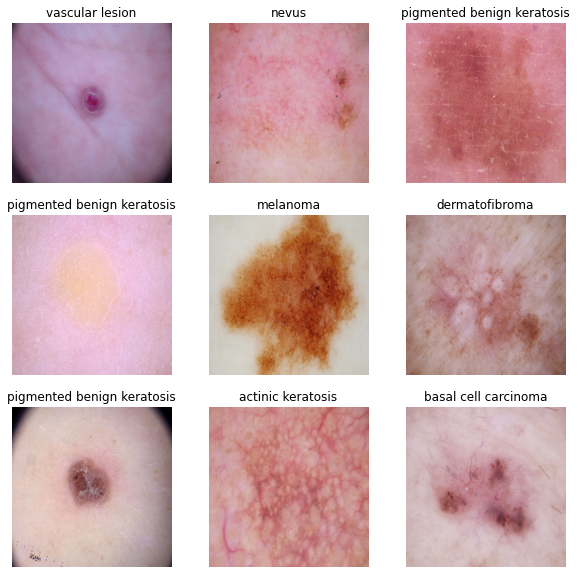

In [ ]:
import matplotlib.pyplot as plt

# plotting some random images
fig = plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### optimizer chozen is 'adam'
### the loss function chosen is SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 73ms/step - loss: 2.0669 - accuracy: 0.1864 - val_loss: 2.0372 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.9733 - accuracy: 0.2333 - val_loss: 1.8516 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7749 - accuracy: 0.3354 - val_loss: 1.6030 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6211 - accuracy: 0.4124 - val_loss: 1.5908 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5984 - accuracy: 0.4252 - val_loss: 1.5597 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5665 - accuracy: 0.4487 - val_loss: 1.5177 - val_accuracy: 0.4698
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4774 - accuracy: 0.4777 - val_loss: 1.4714 - val_accuracy: 0.4832
Epoch 8/20
5

### Visualizing training results

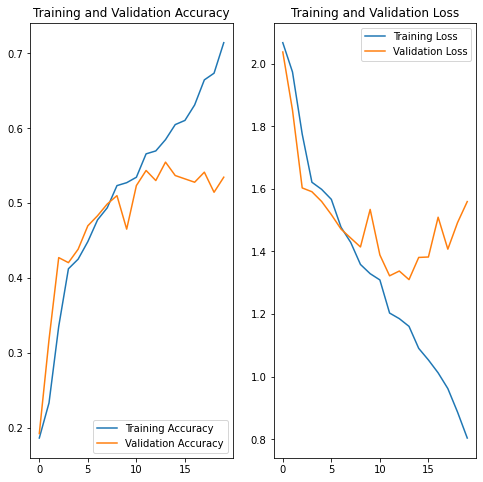

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Model Analysis - Overfitting
The accuracy of the training data is lineraly increasing, where as the accuracy of validation data does not increase after reaching around 50%.
The gap between the training accuracy and validation accuracy is also large enough to conclude that there is clear overfitting.

In [ ]:
# Let us use Augnentation - a method of adding more training data by augmenting the existing training data.
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

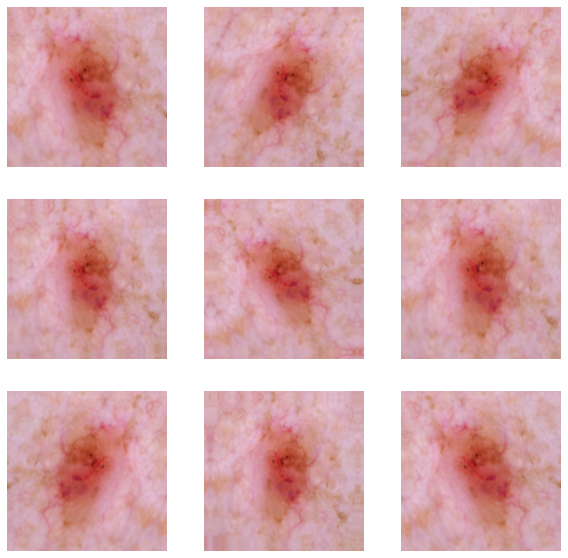

In [ ]:
# visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model with Dropout, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Using a drop out 0f 0.3 after the final conv.
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [ ]:
# Lets use the same optimizer and loss function as earlier.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 30ms/step - loss: 2.0324 - accuracy: 0.2076 - val_loss: 1.9496 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8676 - accuracy: 0.2863 - val_loss: 1.7464 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7765 - accuracy: 0.3544 - val_loss: 1.6964 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6282 - accuracy: 0.3973 - val_loss: 1.5834 - val_accuracy: 0.4497
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4969 - accuracy: 0.4615 - val_loss: 1.5390 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5010 - accuracy: 0.4660 - val_loss: 1.4659 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4139 - accuracy: 0.4989 - val_loss: 1.4345 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

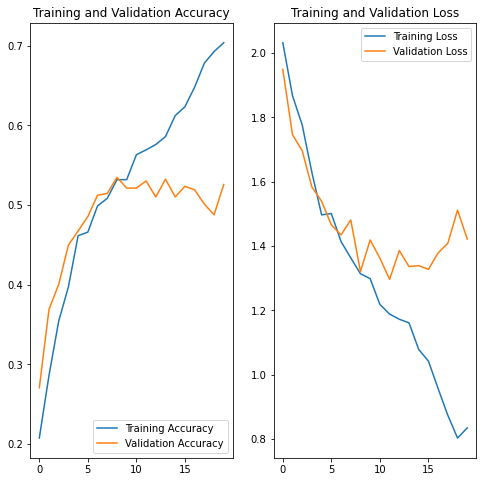

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### There is a slight improvement in the performance of the model. But there is still evidence of over fitting.
The validation accuracy again peaks around 50% and does not grow linearly with the training accuracy.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# Counting the actual files in each subdirectory 
train_data_dir = base_data_dir+"/Train"
total_files = 0
for subdir, dirs, files in os.walk(train_data_dir):
        
    category_name = os.path.basename(subdir)
    
    if category_name == os.path.basename(train_data_dir):
          continue
    num_files = len(files)
    total_files += num_files
    print(str(category_name) + ' has ' + str(num_files) + ' images') 
print("There are a total of " + str(total_files) + " images.")

actinic keratosis has 114 images
vascular lesion has 139 images
melanoma has 438 images
dermatofibroma has 95 images
pigmented benign keratosis has 462 images
basal cell carcinoma has 376 images
nevus has 357 images
seborrheic keratosis has 77 images
squamous cell carcinoma has 181 images
There are a total of 2239 images.


### Findings: 
#### - **seborrheic keratosis** has the least number of samples. It has only 77 images.
#### - **melanoma** has the maximum number of samples. It has 438 images, which is 20% of the data.


## Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=train_data_dir+"/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5658B3FD90>: 100%|██████████| 500/500 [00:17<00:00, 29.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F566E2F8F50>: 100%|██████████| 500/500 [00:16<00:00, 30.66 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F56580C5390>: 100%|██████████| 500/500 [00:16<00:00, 29.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F56580CB510>: 100%|██████████| 500/500 [01:31<00:00,  5.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F565807C910>: 100%|██████████| 500/500 [01:08<00:00,  7.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F56E055EDD0>: 100%|██████████| 500/500 [00:16<00:00, 30.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F56E056B8D0>: 100%|██████████| 500/500 [00:38<00:00, 12.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F56527B5950>: 100%|██████████| 500/500 [00:15<00:00, 32.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F56580FC7D0>: 100%|██████████| 500/500 [00:15<00:00, 31.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [70]:

path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
train_data_dir = base_data_dir+"/Train"
total_files = 0
for subdir, dirs, files in os.walk(train_data_dir):
        
    category_name = os.path.basename(subdir)
    
    if category_name == os.path.basename(train_data_dir):
          continue
    num_files = len(files)
    total_files += num_files
    print(str(category_name) + ' has ' + str(num_files) + ' images') 
print("There are a total of " + str(total_files) + " images.")

actinic keratosis has 114 images
output has 500 images
vascular lesion has 139 images
output has 500 images
melanoma has 438 images
output has 500 images
dermatofibroma has 95 images
output has 500 images
pigmented benign keratosis has 462 images
output has 500 images
basal cell carcinoma has 376 images
output has 500 images
nevus has 357 images
output has 500 images
seborrheic keratosis has 77 images
output has 500 images
squamous cell carcinoma has 181 images
output has 500 images
There are a total of 6739 images.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 24s 136ms/step - loss: 1.9549 - accuracy: 0.2485 - val_loss: 1.6515 - val_accuracy: 0.3749
Epoch 2/30
169/169 [==============================] - 24s 136ms/step - loss: 1.6246 - accuracy: 0.3798 - val_loss: 1.5520 - val_accuracy: 0.4009
Epoch 3/30
169/169 [==============================] - 24s 136ms/step - loss: 1.4615 - accuracy: 0.4345 - val_loss: 1.3095 - val_accuracy: 0.4922
Epoch 4/30
169/169 [==============================] - 24s 138ms/step - loss: 1.3382 - accuracy: 0.4813 - val_loss: 1.2147 - val_accuracy: 0.5412
Epoch 5/30
169/169 [==============================] - 24s 136ms/step - loss: 1.1537 - accuracy: 0.5558 - val_loss: 1.2184 - val_accuracy: 0.5501
Epoch 6/30
169/169 [==============================] - 24s 136ms/step - loss: 1.0364 - accuracy: 0.6079 - val_loss: 1.0608 - val_accuracy: 0.6192
Epoch 7/30
169/169 [==============================] - 24s 136ms/step - loss: 0.8717 - accuracy: 0.6725 - val_loss: 0.8783 - val_ac

#### **Todo:**  Visualize the model results

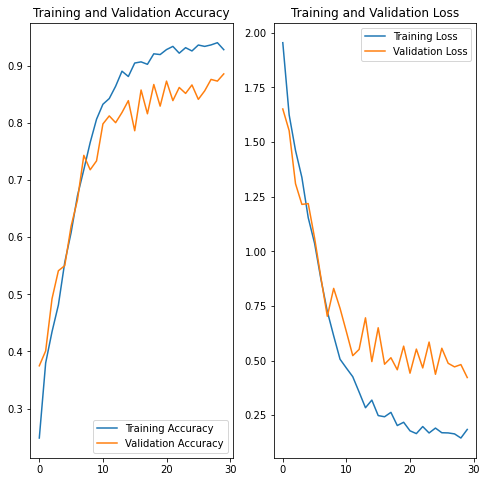

In [ ]:
# Visualize the training and validation accuracy to understand the gap between the two.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

After we handled the class imbalance, the overfitting issue has resolved and the validation accuracy crossed 80% in 11 Epoches.

The model training is slower after adding the augmented data, but it is more accurate.

The Training accuracy is at 94% and the validation accuracy is more than 88%.


### Try the model on a test image and see it can identify it accurately.
Using an image from the melanoma directory of Test.

In [67]:
#Let us use the 0th image in nevus directory.
test_image_path = "/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000000.jpg"

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to nevus with a 100.00 percent confidence.
